<a href="https://colab.research.google.com/github/callmelilypad/-/blob/main/notebooks/WS06_IntroductionToAF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color='#569098' size=20>Introduction to Alphafold!</font>**

##[Return to HomePage](https://github.com/Graylab/DL4Proteins-notebooks)

The implementation of AlphaFold2 is adapted from [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb#scrollTo=11l8k--10q0C)

**OBJECTIVES: By the end of this workshop you should be able to:**

* <font color='#e59454'>Identify and Apply State of the Art Protein Folding and Multitrack Architectures</font>
* <font color='#e59454'>Run the ColabFold implementation of AF2</font>
* <font color='#e59454'>Interpret AF outputs, including plddt scores, coverage, and pae scores</font>
* <font color='#e59454'>Distinguish different protein representations in AlphaFold</font>
* <font color='#e59454'>Enumerate the basic architectural components of AF2</font>

**_To save your work, please save a copy of this notebook into your  personal google drive._**


## **<font color='#569098' size = 5>Table of Contents:**
#### **[Section 1: Introduction](https://colab.research.google.com/drive/1eDrb1ZvvpzhTLyjGi8KGUc-oDpMz042g#scrollTo=ZNmOoXn3MooL&line=1&uniqifier=1)**
* [Introduction: Enter deep learning!](https://colab.research.google.com/drive/1eDrb1ZvvpzhTLyjGi8KGUc-oDpMz042g#scrollTo=vgLg8ZuqMrNm)
* [Introduction: Alphafold as a magic box](https://colab.research.google.com/drive/1eDrb1ZvvpzhTLyjGi8KGUc-oDpMz042g#scrollTo=cuKGEbS3M1XV)

#### **[Section 2: Practical Alphafold](https://colab.research.google.com/drive/1eDrb1ZvvpzhTLyjGi8KGUc-oDpMz042g#scrollTo=PchvZcXB_EED&line=1&uniqifier=1)**
* [Practical Alphafold: Folding a sequence](https://colab.research.google.com/drive/1eDrb1ZvvpzhTLyjGi8KGUc-oDpMz042g#scrollTo=zFiu3-77Lwv3)
* [Practical Alphafold: Interpreting Results](https://colab.research.google.com/drive/1eDrb1ZvvpzhTLyjGi8KGUc-oDpMz042g#scrollTo=XA1chQuQHlOy)
 * [Multiple Sequence Alignment (MSA) Coverage](https://colab.research.google.com/drive/1eDrb1ZvvpzhTLyjGi8KGUc-oDpMz042g#scrollTo=RqdPucMuBJc6)
 * [pLDDT](https://colab.research.google.com/drive/1eDrb1ZvvpzhTLyjGi8KGUc-oDpMz042g#scrollTo=2p_9NU3aLO6o)
 * [Predicted Aligned Error (PAE)](https://colab.research.google.com/drive/1eDrb1ZvvpzhTLyjGi8KGUc-oDpMz042g#scrollTo=g7VWwNOdQ1Mb)


#### **[Section 3: Alphafold Architecture](https://colab.research.google.com/drive/1eDrb1ZvvpzhTLyjGi8KGUc-oDpMz042g#scrollTo=5uBuxvaA5eBZ)**
* [Alphafold Architecture: Input sequence Representation](https://colab.research.google.com/drive/1eDrb1ZvvpzhTLyjGi8KGUc-oDpMz042g#scrollTo=wuH9nL9fHqFx)
* [Alphafold Architecture: Evoformer](https://colab.research.google.com/drive/1eDrb1ZvvpzhTLyjGi8KGUc-oDpMz042g#scrollTo=_lGBhd6VIw3U)
* [Alphafold Architecture: Structure Module](https://colab.research.google.com/drive/1eDrb1ZvvpzhTLyjGi8KGUc-oDpMz042g#scrollTo=Biq7NEcUJtaw)

### <b> <font color='#569098'> Import Libraries

In [ ]:
#@markdown **Please run this cell as you read the introduction**
from google.colab import files
import os
import re
import hashlib
import random
from PIL import Image
import matplotlib.pyplot as plt

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

import os

custom_template_path = None
use_templates = False


USE_AMBER = False
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

jobname = 'import_test'
query_sequence = 'A'
basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()
model_type = "auto"
queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)
download_alphafold_params(model_type, Path("."))

installing colabfold...


# **<font color='#569098'>Section 1: Introduction: A bit of history**

If we know a protein's sequence, what 3D structure will it fold into? This protein folding problem has been a longtime dream of biophysicists, biologists, and protein engineers. Solving holds the key to many new discoveries and innovations for research and drug design!


<center>
    <img src="https://lh3.googleusercontent.com/lpj9wZO1jsPnYPY9LduZ5x7XFfLysEdpjhb7btH2s8SElo2EfZl572isfoSKCTxzNANF1xIHU7YA5gMgoR3p7dkHfgtRQCejZpBY3vMjik_YfLT1=w616" alt="Image" style="max-width: 100%;">
</center>


## **<font color='#569098'>Enter: Deep Learning!</font>**

Yet, although we understood much of the individual physical concepts behind protein folding, there was no recipe of equations that could reliably predict what a protein would fold into.

As examples of 3D experimental protein structures increased, the dataset eventually became large enough to train neural networks to predict how proteins folded.

<html>
  <center>
    <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS0t7-esmbnkkhiQLQgGngtA0JjPCvo6KsMXQ&s"
     width="300"
     height="60">
  </center>
</html>

One of the most famous of these is AlphaFold! It kickstarted a revolution in protein folding by drastically outperforming all competitors in CASP, the yearly protein folding competition.


### **<font color='#e59454'>Question: How do you think AF1 and AF2 affected the median percent accuracy in the 2018 and 2020 CASP benchmarks**
Hint: Previous scores were around 30-40 Global Distance Score (out of 100)

In [ ]:
# @markdown Take a guess!
AF1 = 70 # @param {type:"slider", min:0, max:100, step:10}
AF2 = 50 # @param {type:"slider", min:0, max:100, step:10}

year = [2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020]
casp_scores = [35, 41, 34, 30, 31, 41, 57, 88]

# make bar chart
fig = plt.figure(figsize=(10, 5))
plt.bar(year, casp_scores)
plt.xlabel('Year')
plt.ylabel('CASP Score')

# add prediction as scatter
plt.scatter(2018, AF1, label='AF1', color='purple')
plt.scatter(2020, AF2, label='AF2', color='magenta')
plt.text(2018, AF1, f'{AF1}', ha='right')
plt.text(2020, AF2, f'{AF2}', ha='right')
plt.title('CASP Median Free Modeling Accuracy')

# Set y axis to 0-100
plt.ylim(0, 100)


plt.show()

## **<font color='#569098'>AlphaFold as a Magic Box**

For it's input, AlphaFold takes the sequence and several optional other pieces of information:

1. <font color='#e59454'><u>MSAs</u></font> -- multiple sequence alignments, genetically similar amino acid sequences inferred from a database.

2. <font color='#e59454'><u>Pair Features</u></font> -- a pairwise feature representation of the possible residue interactions.

3. <font color='#e59454'><u>Templates</u></font> -- template proteins that may have similar structure to the unknown protein. These are combined with pair features before thrown into the model's main modules.

Briefly put, these three inputs are fed into the model, which then spits out a protein and some metrics on how plausible AF thinks the structure is. For more information, see subsection **AF Architecture: How Does AF Work?**

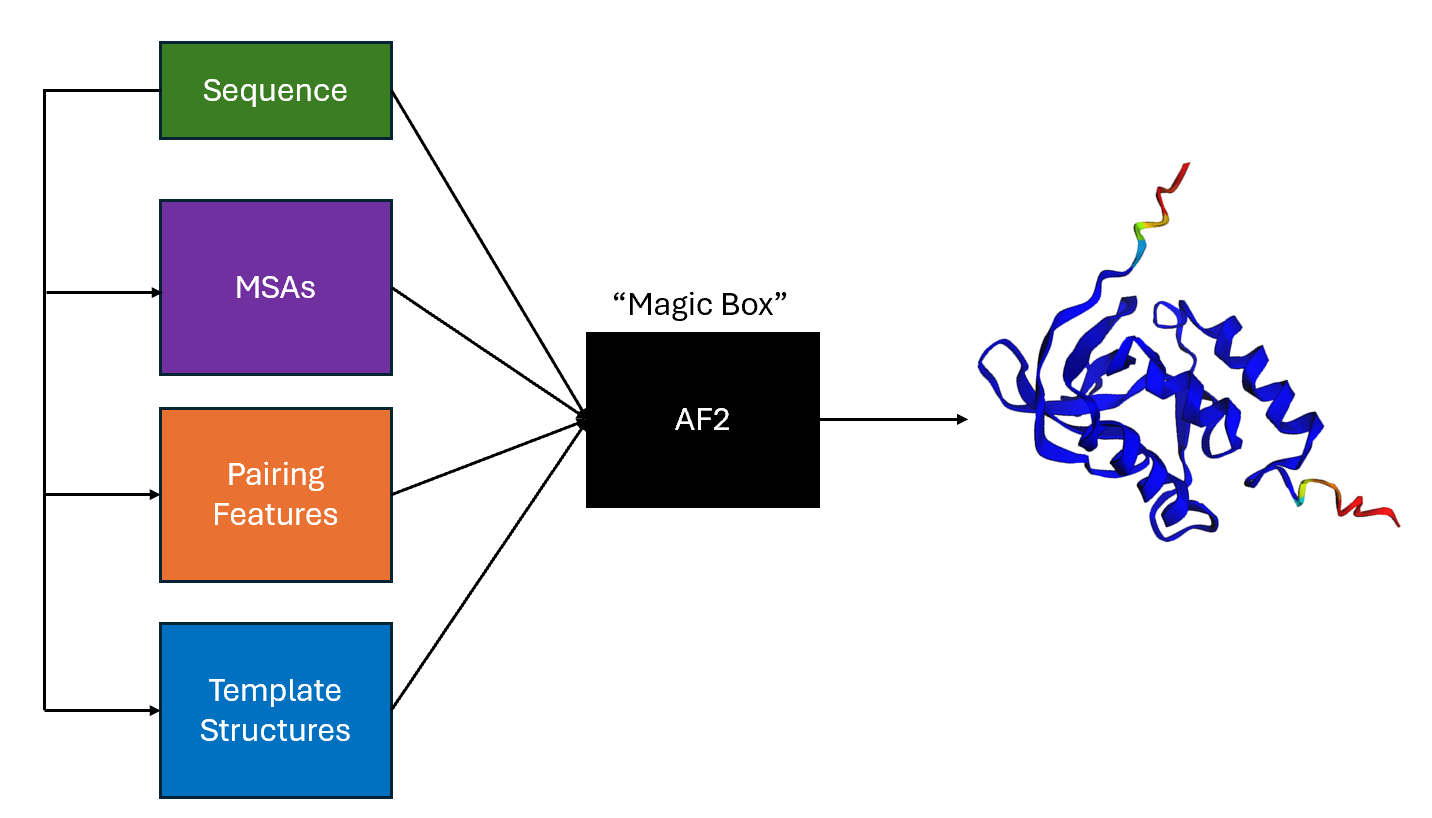

<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="300" align="right" style="height:240px">

# **<font color='#569098'>Section 2: Practical AF-- Folding Proteins (ColabFold)**

Let's get right into it! We have a protein sequence. How do we find it's structure with AlphaFold?

Here, we will use the ColabFold implementation of AF2 ([Mirdita et al. 2022](https://www.nature.com/articles/s41592-022-01488-1)). Usually, we would need to provide MSA alignments, but ColabFold automatically does that for us using MMseqs2. All we have to do is run the cells below, and provide it our sequence (and optionally, templates), and boom, it folds the protein!

Note: When designing de novo proteins, it is recommended to turn MSA off because de novo proteins usually do not have high structural similarities to natural proteins.

Adapted from. For more advanced uses, please visit the [ColabFold Github](https://github.com/sokrypton/ColabFold) page to find notebooks with more options and parameters. This notebook is mainly intended for educational purposes!

## **<font color='#569098'>Part 1: Folding a sequence**

In [ ]:
#@markdown Input your favorite protein sequence, then RUN! (Note: Make sure you are connected to a GPU instance. Should take around 2-5 minutes)
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

#生成独一无二的文件名
def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MTWVRQAPGKGPEWVSGINPDGSSTYYADSVKGRFTISRDNAKNTLYLQMNSLKSEDTALYKCATGAAPRIPTTLRGQGTQVTVSSHHHHHH' #@param {type:"string"}
jobname = 'learning_af'
num_relax = 0   #是否使用 Amber 能量最优化（0 = 不用）
template_mode = "none" #是否使用已有 PDB 模板

use_amber = num_relax > 0

query_sequence = "".join(query_sequence.split())  #去掉序列里的空格和换行，使序列连续

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)   #去掉特殊字符，保证文件夹名 只包含字母、数字和下划线，避免文件系统报错。
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv") #在当前任务文件夹中创建一个同名 .csv 文件
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))



import os

msa_mode = "mmseqs2_uniref_env"  #使用 MMseqs2 工具，从 UniRef 和环境数据库（metagenomic data）里去找相似序列
pair_mode = "unpaired_paired" #同时尝试不配对和配对的方式（兼顾单链和多链情况）。如果是单链预测，这个参数几乎没影响

# decide which a3m to use如果你选择用 MMseqs2 做多序列比对，那么就在任务目录里准备一个 {jobname}.a3m 文件来保存结果。
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)


model_type = "auto"
num_recycles = "3"
recycle_early_stop_tolerance = "auto"
relax_max_iterations = 200
pairing_strategy = "greedy"



max_msa = "auto"
num_seeds = 1
use_dropout = False

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

save_all = False
save_recycles = False
save_to_google_drive = False
dpi = 200
if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")


display_images = True

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")


display_images = False

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=2,
    num_recycles=2,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2], # edited
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")


jobname learning_af_e64d1
sequence MTWVRQAPGKGPEWVSGINPDGSSTYYADSVKGRFTISRDNAKNTLYLQMNSLKSEDTALYKCATGAAPRIPTTLRGQGTQVTVSSHHHHHH
length 92
2024-10-09 17:38:47,646 Running on GPU
2024-10-09 17:38:48,066 Found 5 citations for tools or databases
2024-10-09 17:38:48,067 Query 1/1: learning_af_e64d1 (length 92)


PENDING:   0%|          | 0/150 [elapsed: 00:01 remaining: ?]

2024-10-09 17:38:49,136 Sleeping for 5s. Reason: PENDING


PENDING:   0%|          | 0/150 [elapsed: 00:07 remaining: ?]

2024-10-09 17:38:55,066 Sleeping for 6s. Reason: PENDING


RUNNING:   4%|▍         | 6/150 [elapsed: 00:13 remaining: 05:34]

2024-10-09 17:39:02,012 Sleeping for 5s. Reason: RUNNING


RUNNING:   7%|▋         | 11/150 [elapsed: 00:19 remaining: 03:56]

2024-10-09 17:39:07,932 Sleeping for 8s. Reason: RUNNING


RUNNING:  13%|█▎        | 19/150 [elapsed: 00:28 remaining: 03:01]

2024-10-09 17:39:16,910 Sleeping for 7s. Reason: RUNNING


RUNNING:  17%|█▋        | 26/150 [elapsed: 00:36 remaining: 02:38]

2024-10-09 17:39:24,835 Sleeping for 8s. Reason: RUNNING


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:47 remaining: 00:00]


2024-10-09 17:39:36,982 Setting max_seq=512, max_extra_seq=5120
2024-10-09 17:40:15,080 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=80 pTM=0.667
2024-10-09 17:40:21,715 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=82.1 pTM=0.692 tol=0.583
2024-10-09 17:40:28,410 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=82.7 pTM=0.702 tol=0.111
2024-10-09 17:40:28,412 alphafold2_ptm_model_1_seed_000 took 37.7s (2 recycles)
2024-10-09 17:40:35,204 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=84.9 pTM=0.742
2024-10-09 17:40:42,062 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=85.2 pTM=0.742 tol=0.834
2024-10-09 17:40:48,939 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=85.8 pTM=0.749 tol=0.14
2024-10-09 17:40:48,940 alphafold2_ptm_model_2_seed_000 took 20.5s (2 recycles)
2024-10-09 17:40:48,961 reranking models by 'plddt' metric
2024-10-09 17:40:48,961 rank_001_alphafold2_ptm_model_2_seed_000 pLDDT=85.8 pTM=0.749
2024-10-09 17:40:48,962 rank_002_alphafold2_ptm_model_1_seed_000 pLDDT=8

0

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

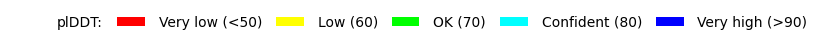

In [ ]:
#@markdown Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT"
show_sidechains = True #@param {type:"boolean"}显示侧链原子
show_mainchains = False

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()

## **<font color='#569098'>Part 2: How do we interpret the results?**</font>

If you were to download the outputs (packaged conveniently on the actual ColabFold notebook, or less conveniently in the files for this notebook), you will get several files of interest:

1. Several <font color='#e59454'>"ranked" 3D pdb models </font>
2. An image detailing the <font color='#e59454'>"coverage"</font>
3. An image detailing the <font color='#e59454'>"pLDDT"</font>
4. An image detailing the <font color='#e59454'>"PAE"</font>



Let's look into what each means!

### **<font color='#569098'>MSA Coverage - How much similar sequences are there in nature?**

"Coverage" is pretty straightforward- when AF looks into its database of sequences, the coverage shows how many matches it was able to assign for parts of the input sequence.


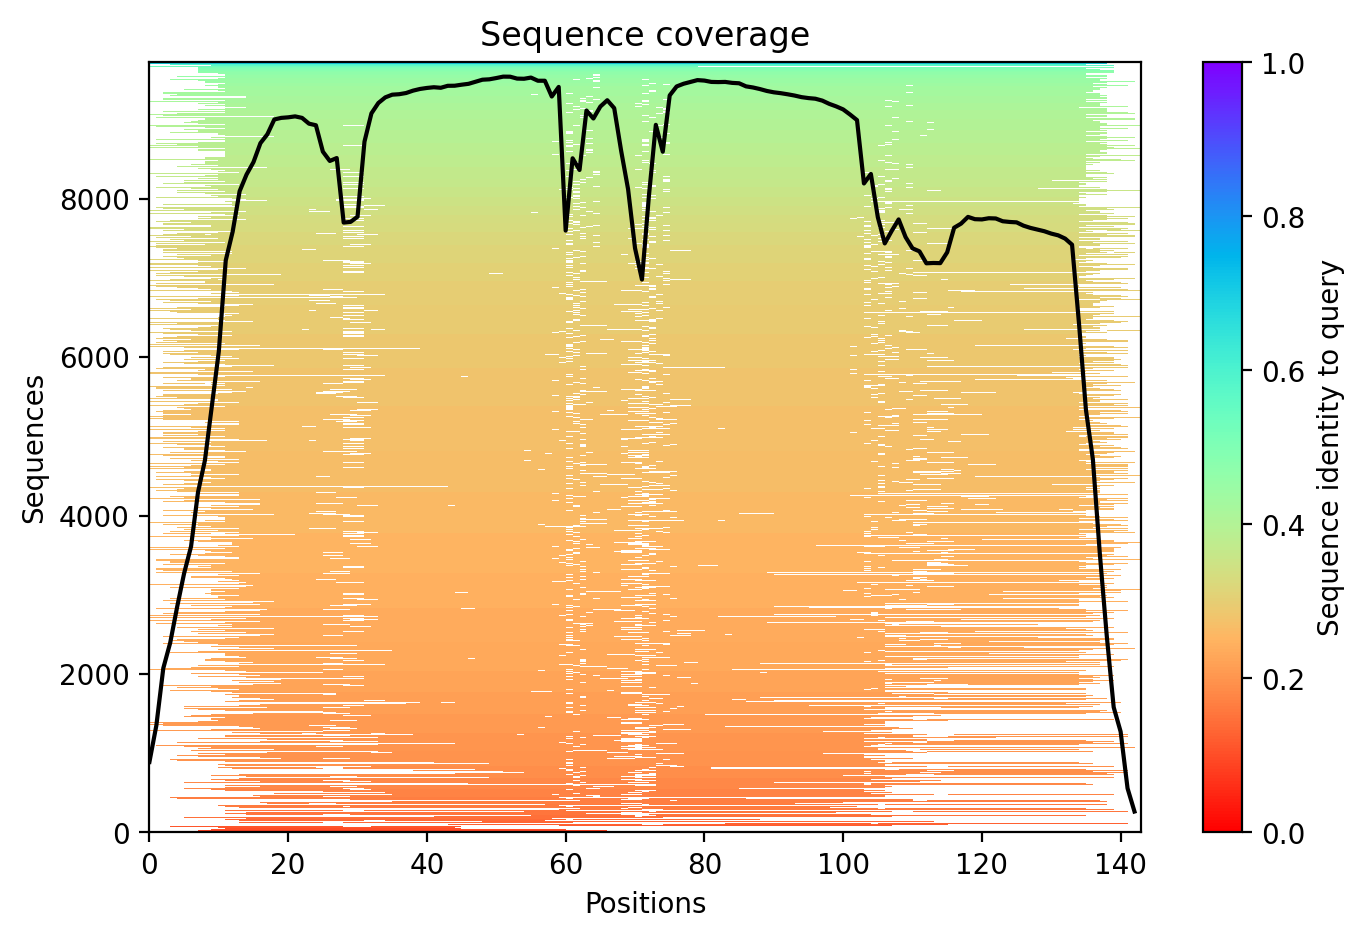

In [ ]:
#@markdown Run to show the MSA coverage of your protein - Is there a lot or a little coverage? (hint: more colors = more coverage)
from IPython.display import display, HTML, Image
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
display(Image(url=cov, width=800, height=500))


### **<font color='#e59454'>Question: Which protein (left or right) do you think has more sequence coverage coverage? What does it mean to have more coverage?**

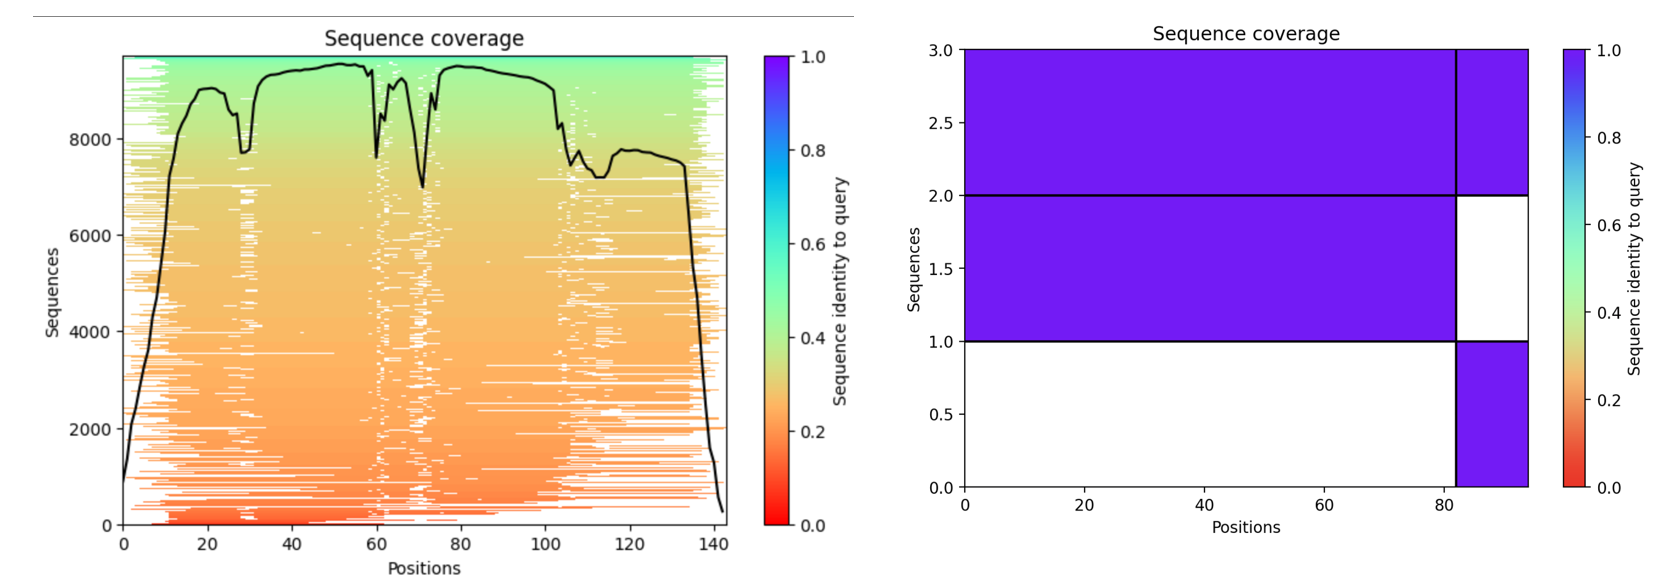

In [1]:
#@markdown <font color='#e59454'>Question Time! Run to Show Question
from IPython.display import HTML, display
from ipywidgets import widgets

def create_answer_box(question, correct_answer):
    def display_answer(button):
        user_answer = text_area.value.strip()
        result.value = f"<pre class='answer-text'><b>{correct_answer}</b></pre>"

    # Create widgets
    text_area = widgets.Textarea(
        placeholder='Enter your answer here...',
        layout={'width': '95%', 'height': '100px'}
    )
    submit_button = widgets.Button(description="Submit")
    result = widgets.HTML(value="")

    # Set up the layout
    vbox = widgets.VBox([text_area, submit_button, result])

    # Add button click event
    submit_button.on_click(display_answer)

    # Display the widget
    display(HTML(f"<b>{question}</b>"))
    display(vbox)

    # Add custom CSS for text wrapping
    display(HTML("""
    <style>
    .widget-html-content {
        width: 95%;
        white-space: normal;
        word-wrap: break-word;
    }
    .answer-text {
        width: 90%;
        color: green;
        line-height: 1.5;
        white-space: pre-wrap;
        word-wrap: break-word;
        font-family: inherit;
        font-size: inherit;
        margin: 0;
        padding: 0;
    }
    </style>
    """))

# Example usage
create_answer_box('Which one has more coverage?', 'Trick question!!! The one one the left has lots of coverage, as it is a highly documented natural protein (Snase), with many similar sequences in the MSA database. On the other hand, the one on the right is a complex folded without MSAs. We want to do this when folding de novo proteins- as they are not as evolutionarily related/structrually related to similar sequences found in nature, and would mess with the inference.')

### **<font color='#569098'>pLDDT - predicted local distance difference test score**

pLDDT can be interpreted as the per-residue confidence that AF has in its prediction. A higher pLDDT means the prediction is more accurate.

From Deepmind's website,

* <font color='#e59454'>\>90 = High accuracy</font>
* <font color='#e59454'>70-90 = Modeled well</font>
* <font color='#e59454'>50-70 = Low confidence</font>
* <font color='#e59454'><50 = Probably disordered region
</font>

The overall pLDDT is used to rank the outputs (and the structure we visualized is colored by pLDDT -- blue is higher and red is lower)


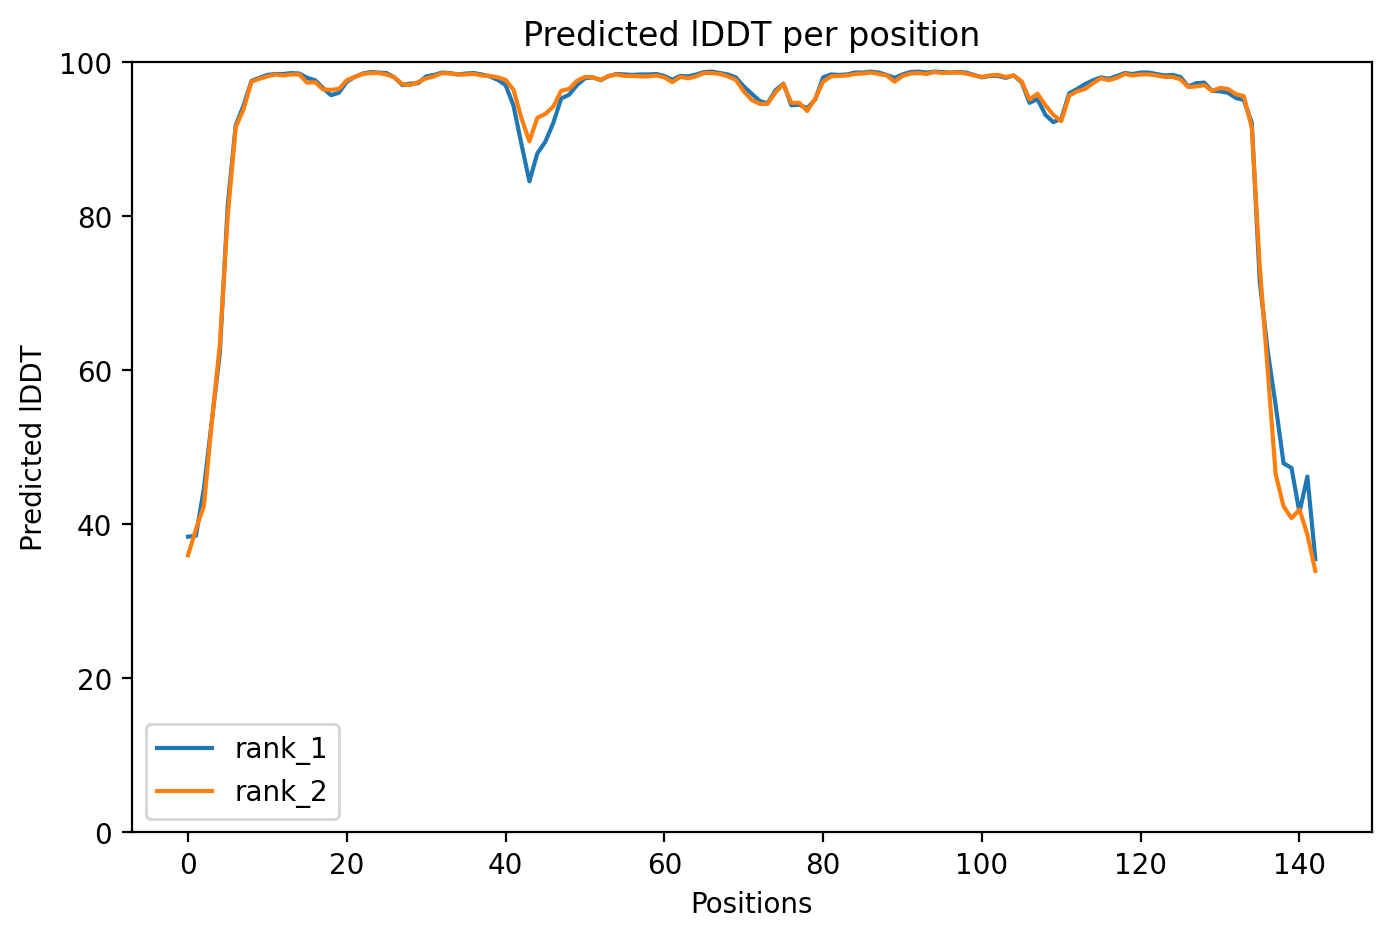

In [ ]:
#@markdown Run to display your pLDDT score - Is it high confidence? Where might AF2 be less confident?
from IPython.display import display, HTML, Image
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(Image(url=cov, width=800, height=500))

### **<font color='#e59454'>Question: Between the left and right folded proteins, which one is more likely to mirror experimental results?**


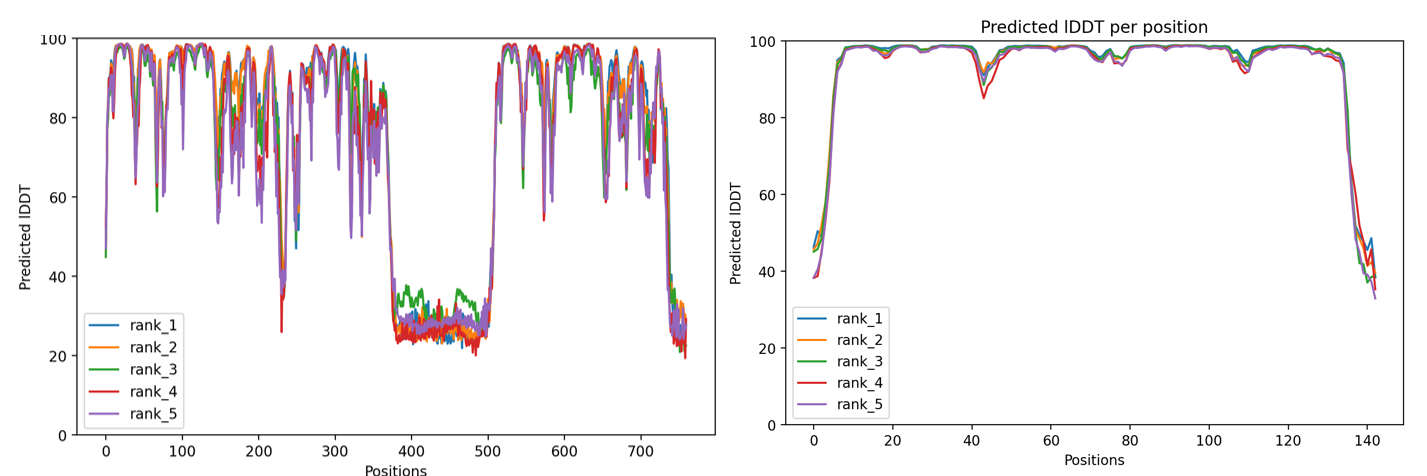

In [ ]:
#@markdown <font color='#e59454'>Question Time! Run to Show Question
from IPython.display import HTML, display
from ipywidgets import widgets

def create_answer_box(correct_answer):
    def display_answer(button):
        user_answer = text_area.value.strip()
        result.value = f"<pre class='answer-text'><b>{correct_answer}</b></pre>"

    # Create widgets
    text_area = widgets.Textarea(
        placeholder='Enter your answer here...',
        layout={'width': '95%', 'height': '100px'}
    )
    submit_button = widgets.Button(description="Submit")
    result = widgets.HTML(value="")

    # Set up the layout
    vbox = widgets.VBox([text_area, submit_button, result])

    # Add button click event
    submit_button.on_click(display_answer)

    # Display the widget
    display(HTML("<b>Which one is AF more confident in? Why?</b>"))
    display(vbox)

    # Add custom CSS for text wrapping
    display(HTML("""
    <style>
    .widget-html-content {
        width: 95%;
        white-space: normal;
        word-wrap: break-word;
    }
    .answer-text {
        width: 90%;
        color: green;
        line-height: 1.5;
        white-space: pre-wrap;
        word-wrap: break-word;
        font-family: inherit;
        font-size: inherit;
        margin: 0;
        padding: 0;
    }
    </style>
    """))

# Example usage
create_answer_box('Alphafold has more confidence in the right one! This is because the plddt is higher (there are less "spikes")')

### **<font color='#569098'>PAE - predicted aligned error**

Represents AF's confidence for the interaction of protein domains and residues. Given in a contact map between all residues.

The color at (x, y) corresponds to the expected distance error in residue x’s position, when the prediction and true structure are aligned on residue y.

Lower is better:
* Low = well defined positions/orientation (blue)
* High = uncertain relative positions (red)

For example: If a nanobody binds well to an antigen, we would expect to see more "blue" in the interaction regions between the two chains (see the question below for an example)


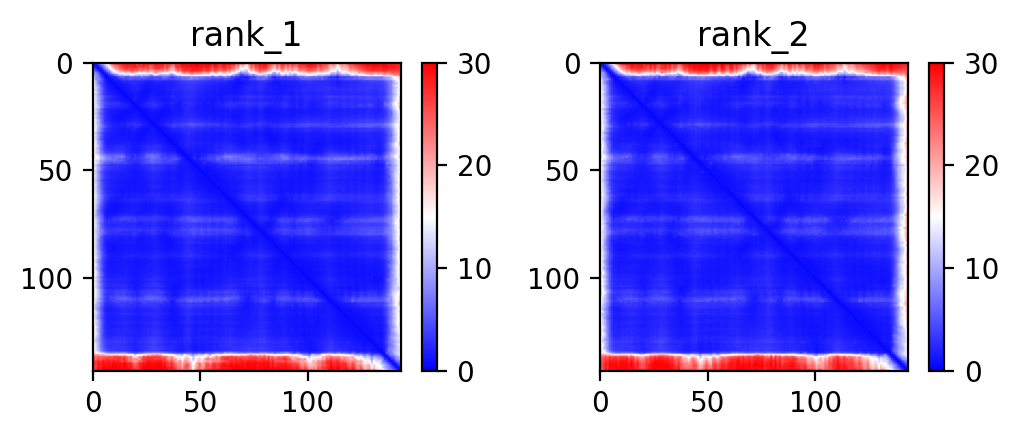

In [ ]:
#@markdown Run to view PAE charts - take time to understand what the x and y axes mean!
from IPython.display import display, HTML, Image
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')
pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)

display(HTML(f"""
<div style="max-width:90%; padding:2em;">
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
</div>
"""))

### **<font color='#e59454'>Question: The following is a PAE diagram between two proteins, A and B. Which of the four quadrants (1,2,3,4) will detail any interactions between the two proteins? Bonus: Is the PAE diagram a perfect mirror across the x-y axis?**

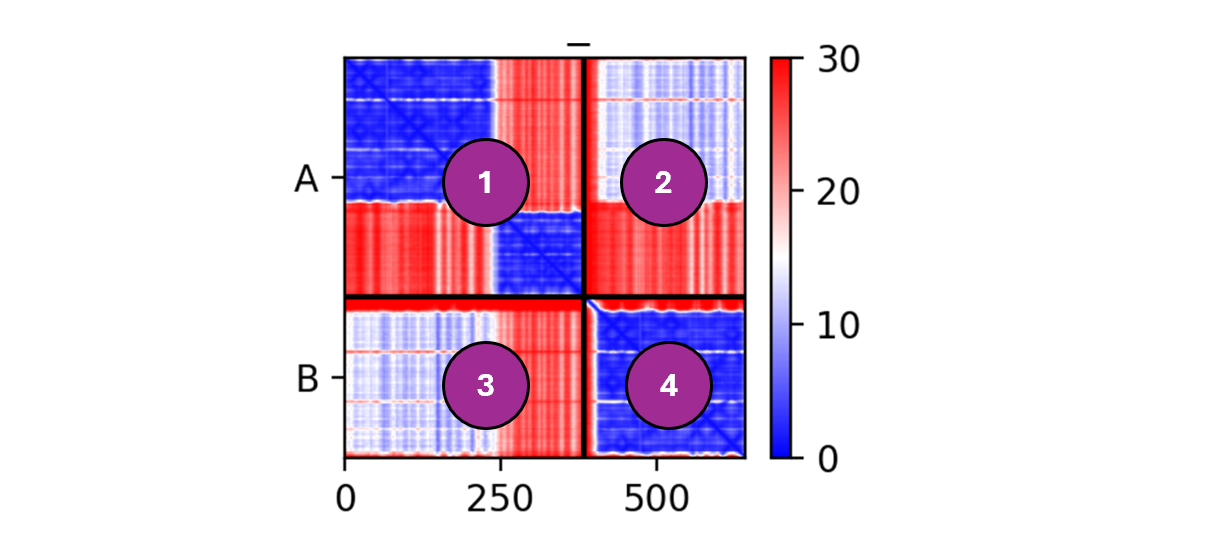

In [ ]:
#@markdown <font color='#e59454'>Question Time! Run to Show Question
from IPython.display import HTML, display
from ipywidgets import widgets

def create_answer_box(correct_answer):
    def display_answer(button):
        user_answer = text_area.value.strip()
        result.value = f"<pre class='answer-text'><b>{correct_answer}</b></pre>"

    # Create widgets
    text_area = widgets.Textarea(
        placeholder='Enter your answer here...',
        layout={'width': '95%', 'height': '100px'}
    )
    submit_button = widgets.Button(description="Submit")
    result = widgets.HTML(value="")

    # Set up the layout
    vbox = widgets.VBox([text_area, submit_button, result])

    # Add button click event
    submit_button.on_click(display_answer)

    # Display the widget
    display(HTML("<b>Which quadrants represent intermolecular interactions? Is the figure mirrored? Why or why not?</b>"))
    display(vbox)

    # Add custom CSS for text wrapping
    display(HTML("""
    <style>
    .widget-html-content {
        width: 95%;
        white-space: normal;
        word-wrap: break-word;
    }
    .answer-text {
        width: 90%;
        color: green;
        line-height: 1.5;
        white-space: pre-wrap;
        word-wrap: break-word;
        font-family: inherit;
        font-size: inherit;
        margin: 0;
        padding: 0;
    }
    </style>
    """))

# Example usage
create_answer_box("2 & 3 show weak interactions between the two proteins. However, it should be noted that the PAE diagram is not exactly a perfect mirror. If there is different aligned error based on which residue we align on, the difference that will be reflected in the diagram")

### More Files

Below is a summary of all the files produced after running AlphaFold

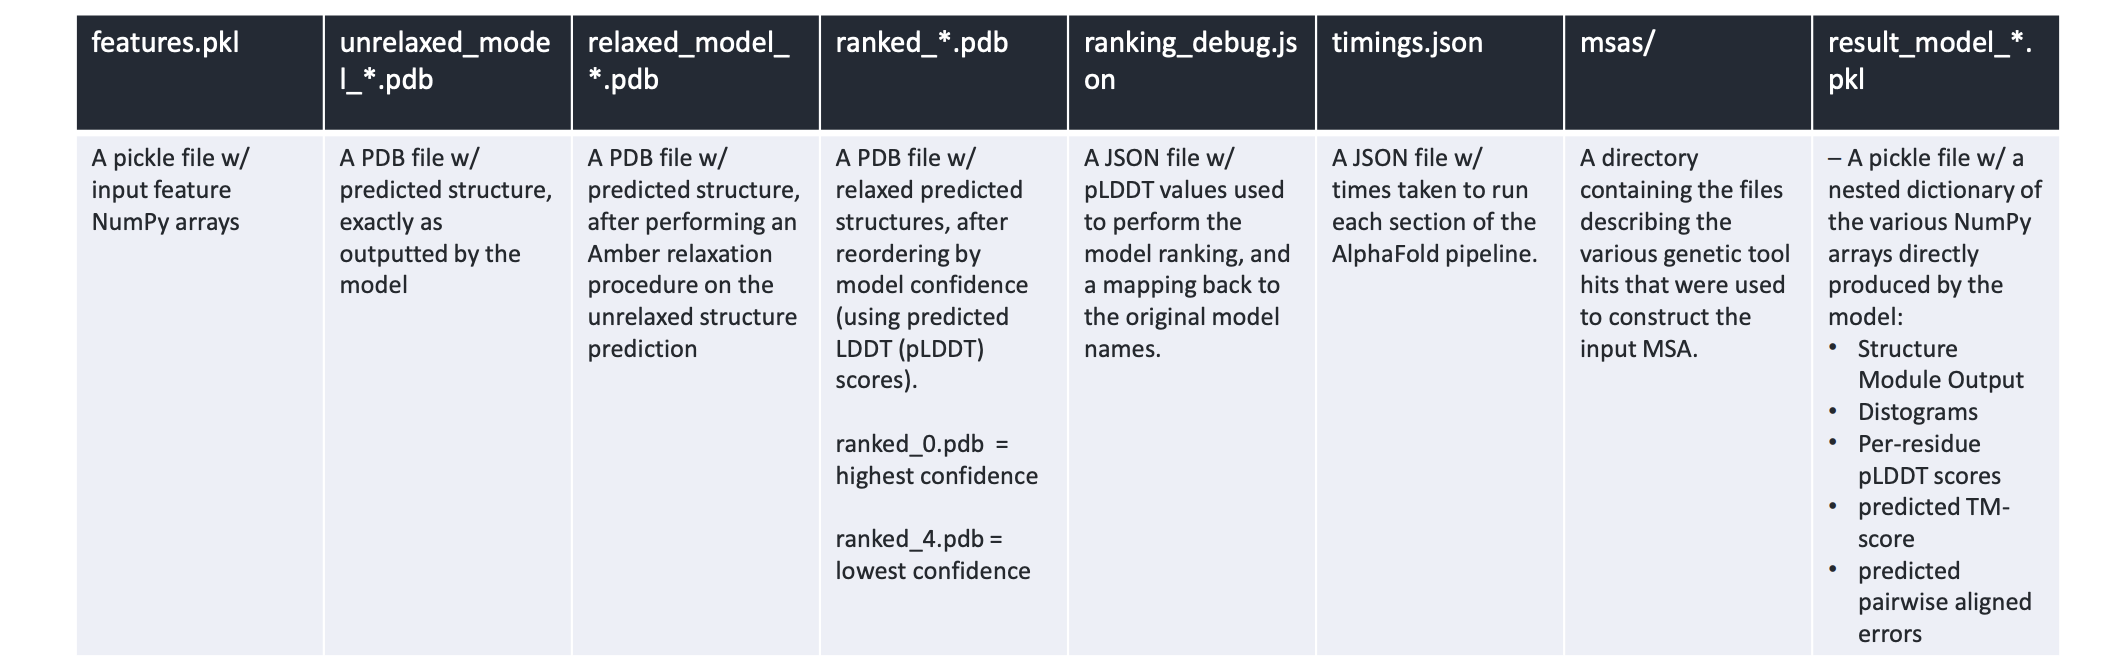

# **<font color='#569098'>Section 3: AF Architecture-- How Does AF Work?**

AF utilized many innovations, including multi-track architecture, multiple-sequence alignments, end-to-training, attention, and its own confidence estimator. Don't worry if you don't understand these terms, we will go into it!

Below are the three main components of AF2's architecture that we talked about before:

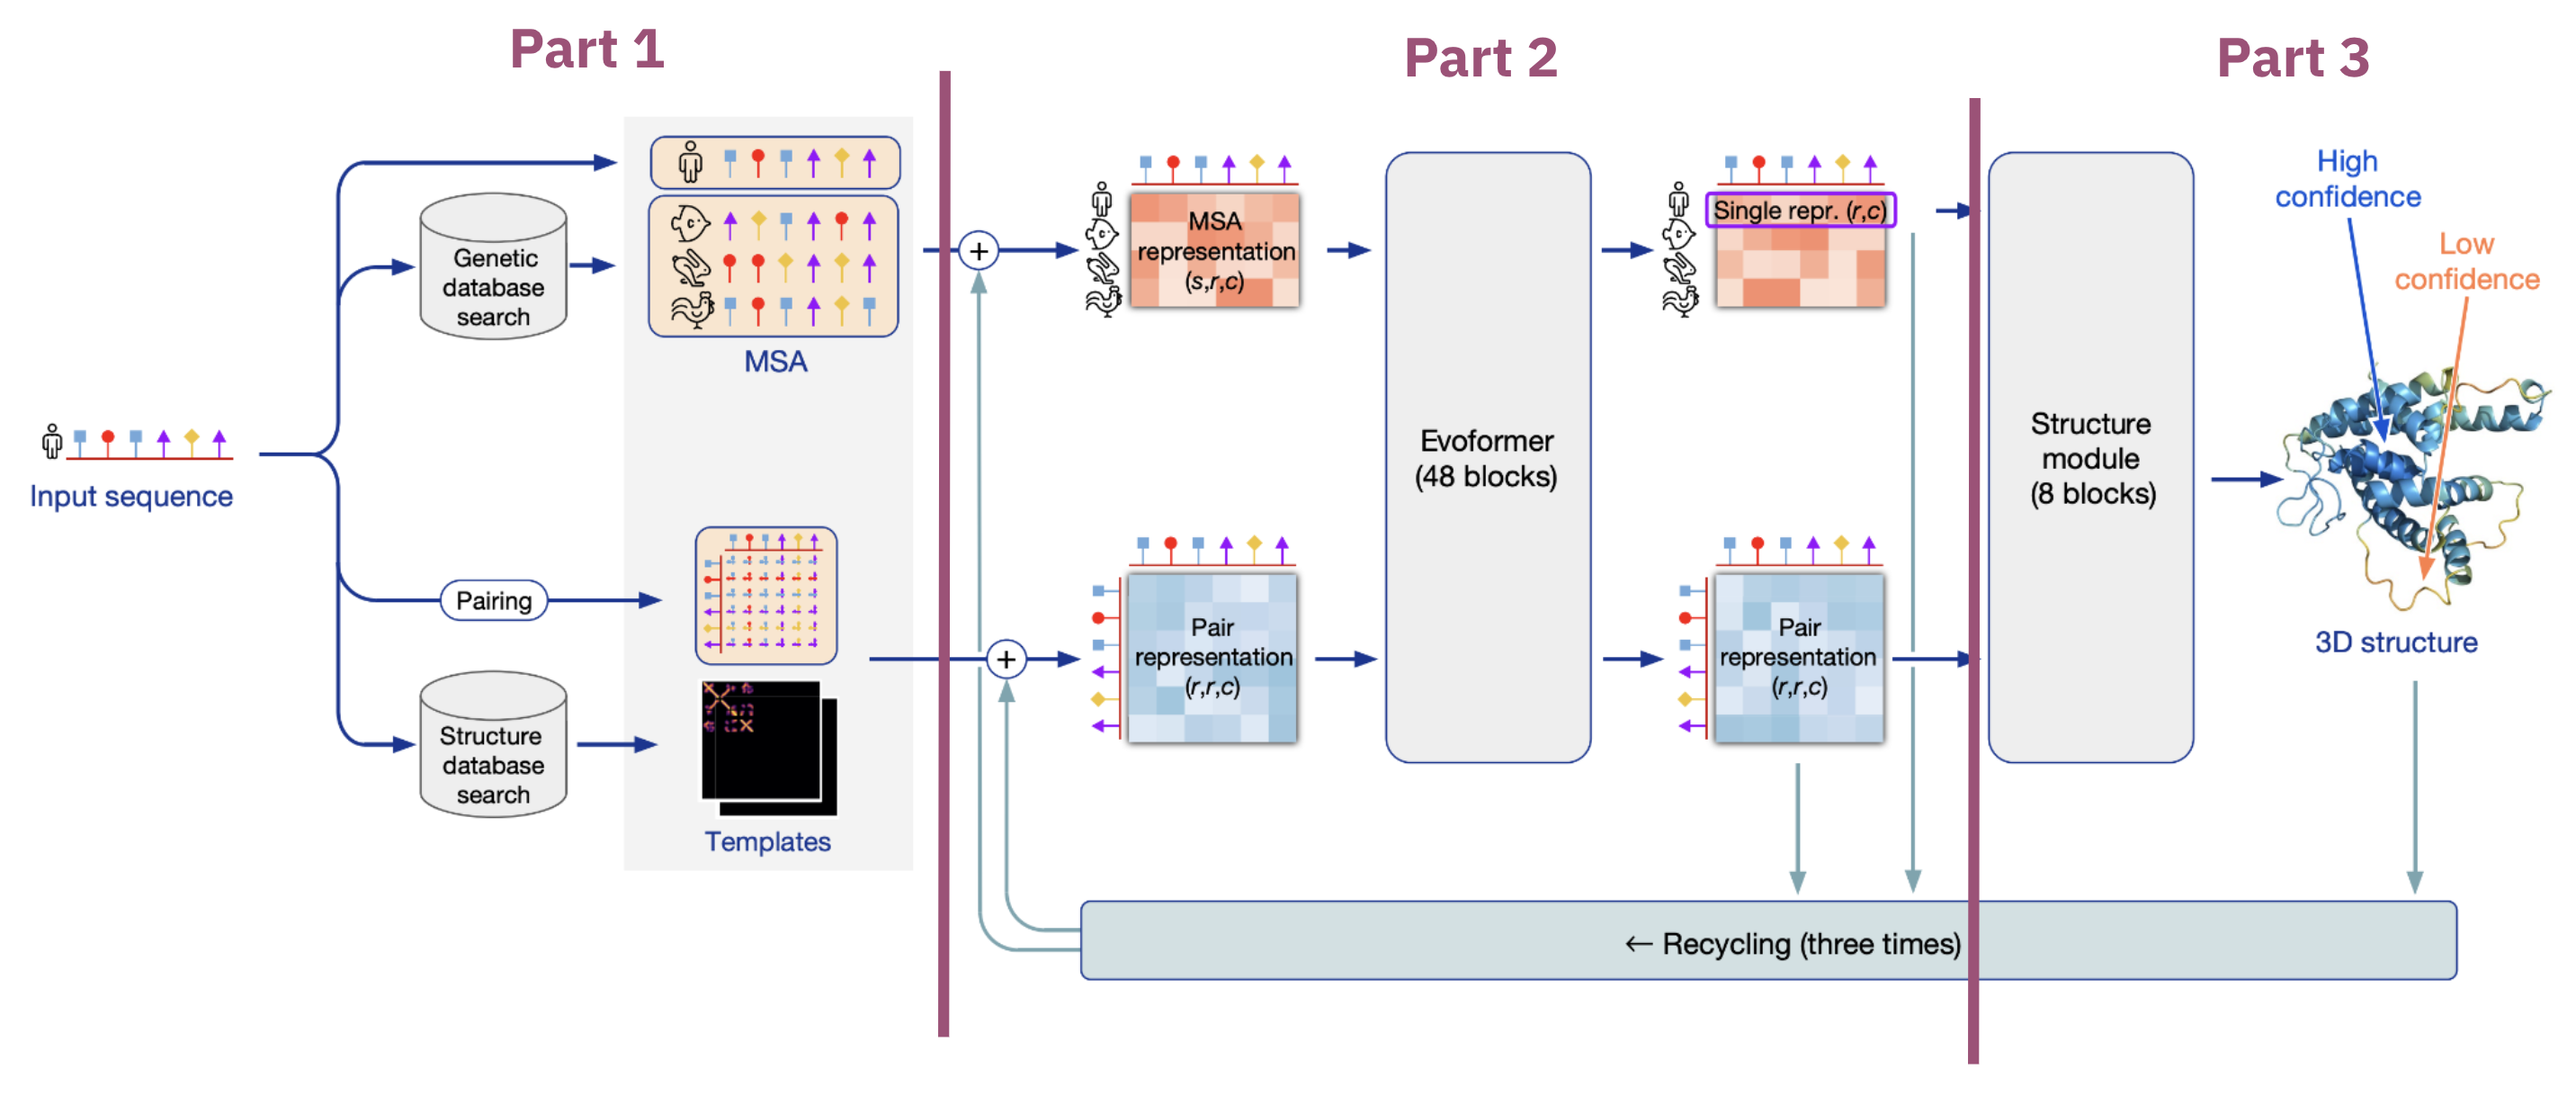

## **<font color='#569098'>Part 1: Representations of our input sequence**

### <font color='#569098'>Protein sequence information


Protein sequence information fed to AlphaFold 2 are stored as a fasta file. Here's an example below:

```
>sp|P46598|HSP90_CANAL Heat shock protein 90 homolog OS=Candida albicans
(strain SC5314 / ATCC MYA-2876) OX=237561 GN=HSP90 PE=1 SV=1

MADAKVETHEFTAEISQLMSLIINTVYSNKEIFLRELISNASDALDKIRYQALSDPSQLE
SEPELFIRIIPQKDQKVLEIRDSGIGMTKADLVNNLGTIAKSGTKSFMEALSAGADVSMI
GQFGVGFYSLFLVADHVQVISKHNDDEQYVWESNAGGKFTVTLDETNERLGRGTMLRLFL
KEDQLEYLEEKRIKEVVKKHSEFVAYPIQLVVTKEVEKEVPETEEEDKAAEEDDKKPKLE
EVKDEEDEKKEKKTKTVKEEVTETEELNKTKPLWTRNPSDITQDEYNAFYKSISNDWEDP
LAVKHFSVEGQLEFRAILFVPKRAPFDAFESKKKKNNIKLYVRRVFITDDAEELIPEWLS
FIKGVVDSEDLPLNLSREMLQQNKILKVIRKNIVKKMIETFNEISEDQEQFNQFYTAFSK
NIKLGIHEDAQNRQSLAKLLRFYSTKSSEEMTSLSDYVTRMPEHQKNIYYITGESIKAVE
KSPFLDALKAKNFEVLFMVDPIDEYAMTQLKEFEDKKLVDITKDFELEESDEEKAAREKE
IKEYEPLTKALKDILGDQVEKVVVSYKLVDAPAAIRTGQFGWSANMERIMKAQALRDTTM
SSYMSSKKTFEISPSSPIIKELKKKVETDGAEDKTVKDLTTLLFDTALLTSGFTLDEPSN
FAHRINRLIALGLNIDDDSEETAVEPEATTTASTDEPAGESAMEEVD
```

### <font color='#569098'>Building a multiple sequence alignment and template structure

The input amino acid sequence is used as a query to several databases (normally UniRef) of protein sequences and constructs a *multiple sequence alignment* (MSA). An MSA identifies similar (but not identical) sequences that have been identified in living organisms.  How does one go from an alignment to a structure? The theory is that residues that coevolve are generally close to each other in the protein’s folded state.

The similar sequences pulled from also have structural information. These templates can be converted into distance matrices to determine the distance between residues



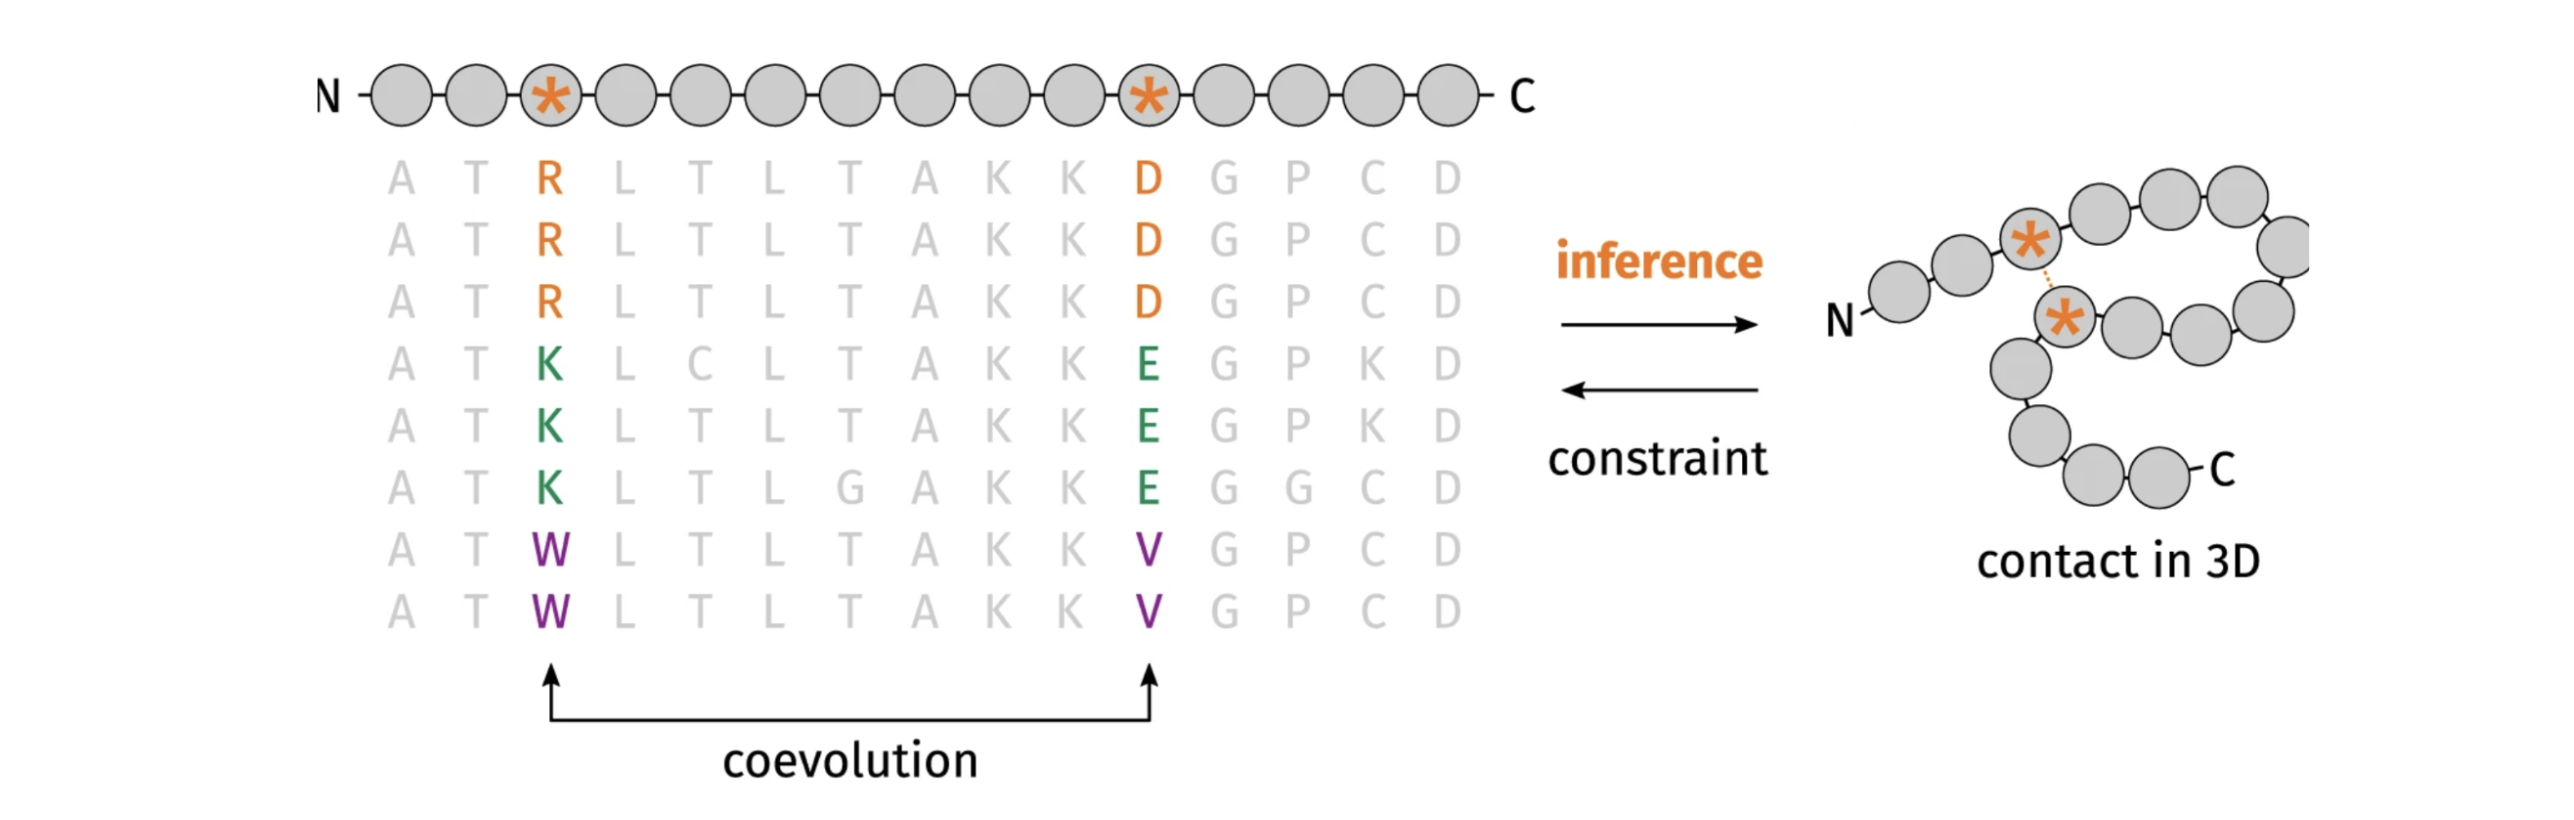

In [ ]:
#@markdown **<font color='#e59454'>Question Time! Run to Show Question**
import random
from IPython.display import display, HTML


def create_quiz(question, correct_answer, decoy_answers):
    # Combine the correct answer with the decoy answers
    answers = [correct_answer] + decoy_answers

    # Shuffle the answers
    random.shuffle(answers)

    # Generate the HTML code
    html_code = f"""
    <div style="font-family: Arial, sans-serif; margin: 30px; max-width: 1000px;">
      <h3 style="word-wrap: break-word;">{question}</h3>
    """

    # Add each answer as a radio button
    for i, answer in enumerate(answers):
        html_code += f"""
        <div style="word-wrap: break-word; margin-bottom: 10px;">
          <input type="radio" id="option{i}" name="quiz" value="{answer}">
          <label for="option{i}" id="label{i}">{answer}</label>
        </div>
        """

    # Add the submit button and feedback section
    html_code += f"""
      <button onclick="checkAnswer()">Submit</button>
      <p id="feedback" style="font-weight: bold;"></p>
    </div>
    <script>
    function checkAnswer() {{
        var radios = document.getElementsByName('quiz');
        var correctAnswer = "{correct_answer}";
        var feedback = document.getElementById('feedback');
        var selectedOption = null;
        var selectedLabel = null;

        // Get the selected option
        for (var i = 0, length = radios.length; i < length; i++) {{
            if (radios[i].checked) {{
                selectedOption = radios[i].value;
                selectedLabel = document.getElementById('label' + i);
                break;
            }}
        }}

        // Provide feedback
        if (selectedOption) {{
            if (selectedOption === correctAnswer) {{
                feedback.textContent = "Correct!";
                feedback.style.color = "green";
                selectedLabel.style.color = "green";
            }} else {{
                feedback.textContent = "Incorrect.";
                feedback.style.color = "red";
                selectedLabel.style.color = "red";
            }}
        }} else {{
            feedback.textContent = "Please select an answer.";
            feedback.style.color = "orange";
        }}
    }}
    </script>
    """

    display(HTML(html_code))

# Example
question = "What is an MSA and why is it important for AF2?"
correct_answer = "An MSA is a sequence alignment of protein sequences that identifies similar, but not identical, sequences across different organisms. It is important because it helps determine which parts of the sequence are more likely to mutate and allows the detection of correlations between amino acids, providing crucial evolutionary information for predicting protein structure."
decoy_answers = ["An MSA is a matrix of sequence alignments that highlights the most conserved regions in a protein sequence. For AF2, it’s important because it helps in quantifying the stability of different protein folds by analyzing these conserved regions.",
                 "An MSA is a method for annotating sequences based on their biochemical properties. It’s essential for AF2 as it helps classify sequences into functional categories, which can then be used to infer protein structure.",
                 "An MSA is a multi-sequence alignment used to determine the secondary structure of proteins. It is crucial for AF2 because it provides a visual representation of how protein structures align with one another, aiding in the prediction of tertiary structures."]

create_quiz(question, correct_answer, decoy_answers)

Here, we also try to identify *templates*, which are proteins that may have similar structure to that of the input sequence. This is used to construct an initial representation of the structure, also known as the *pair representation*. By identifying conserved fragments, the model uses this as a guide to construct a structure.

In [ ]:
#@markdown **<font color='#e59454'>Question Time! Run to Show Question**
import random
from IPython.display import display, HTML


question = "What is the concept of “pair representation” in AF2?"
correct_answer = "Pair representation in AF2 is a model of the likelihood that pairs of amino acids will be in contact with each other. It is an intermediate representation that is refined through the Evoformer module and used to inform the final structure prediction of the protein."
decoy_answers = ["Pair representation in AF2 is a method for visualizing the three-dimensional arrangement of amino acid side chains. It provides AF2 with a detailed spatial map of side chains, crucial for understanding the overall protein shape.",
                 "Pair representation in AF2 denotes the alignment of protein sequences based on evolutionary relationships. It allows AF2 to identify homologous pairs of sequences and infer structural similarities.",
                 "Pair representation in AF2 is a technique for quantifying the hydrophobic interactions between amino acids. It’s used to estimate the internal energy of the protein structure and refine predictions of protein folding."]

create_quiz(question, correct_answer, decoy_answers)

## **<font color='#569098'>Part 2: Evoformer**

Here, we take the MSA and templates and pass them through a pair of transformers. Doing so (1) identifies which pieces of information are more informative, (2) iteratively exchanges information between MSA and pair representations, and (3) refines the representations for both the MSA and pair interactions.

Below is a deeper look into the Evoformer (which is composed of an MSA transformer and pair transformer). Left image: The MSA transformer identifies a correlation between the two columns of the MSA, each corresponding to a residue. This information is passed to the pair representation, where subsequently the pair representation identifies another possible interaction. Right image: Information is passed back to the MSA. The MSA transformer receives an input from the pair representation and observes another pair of columns that exhibit a significant correlation.

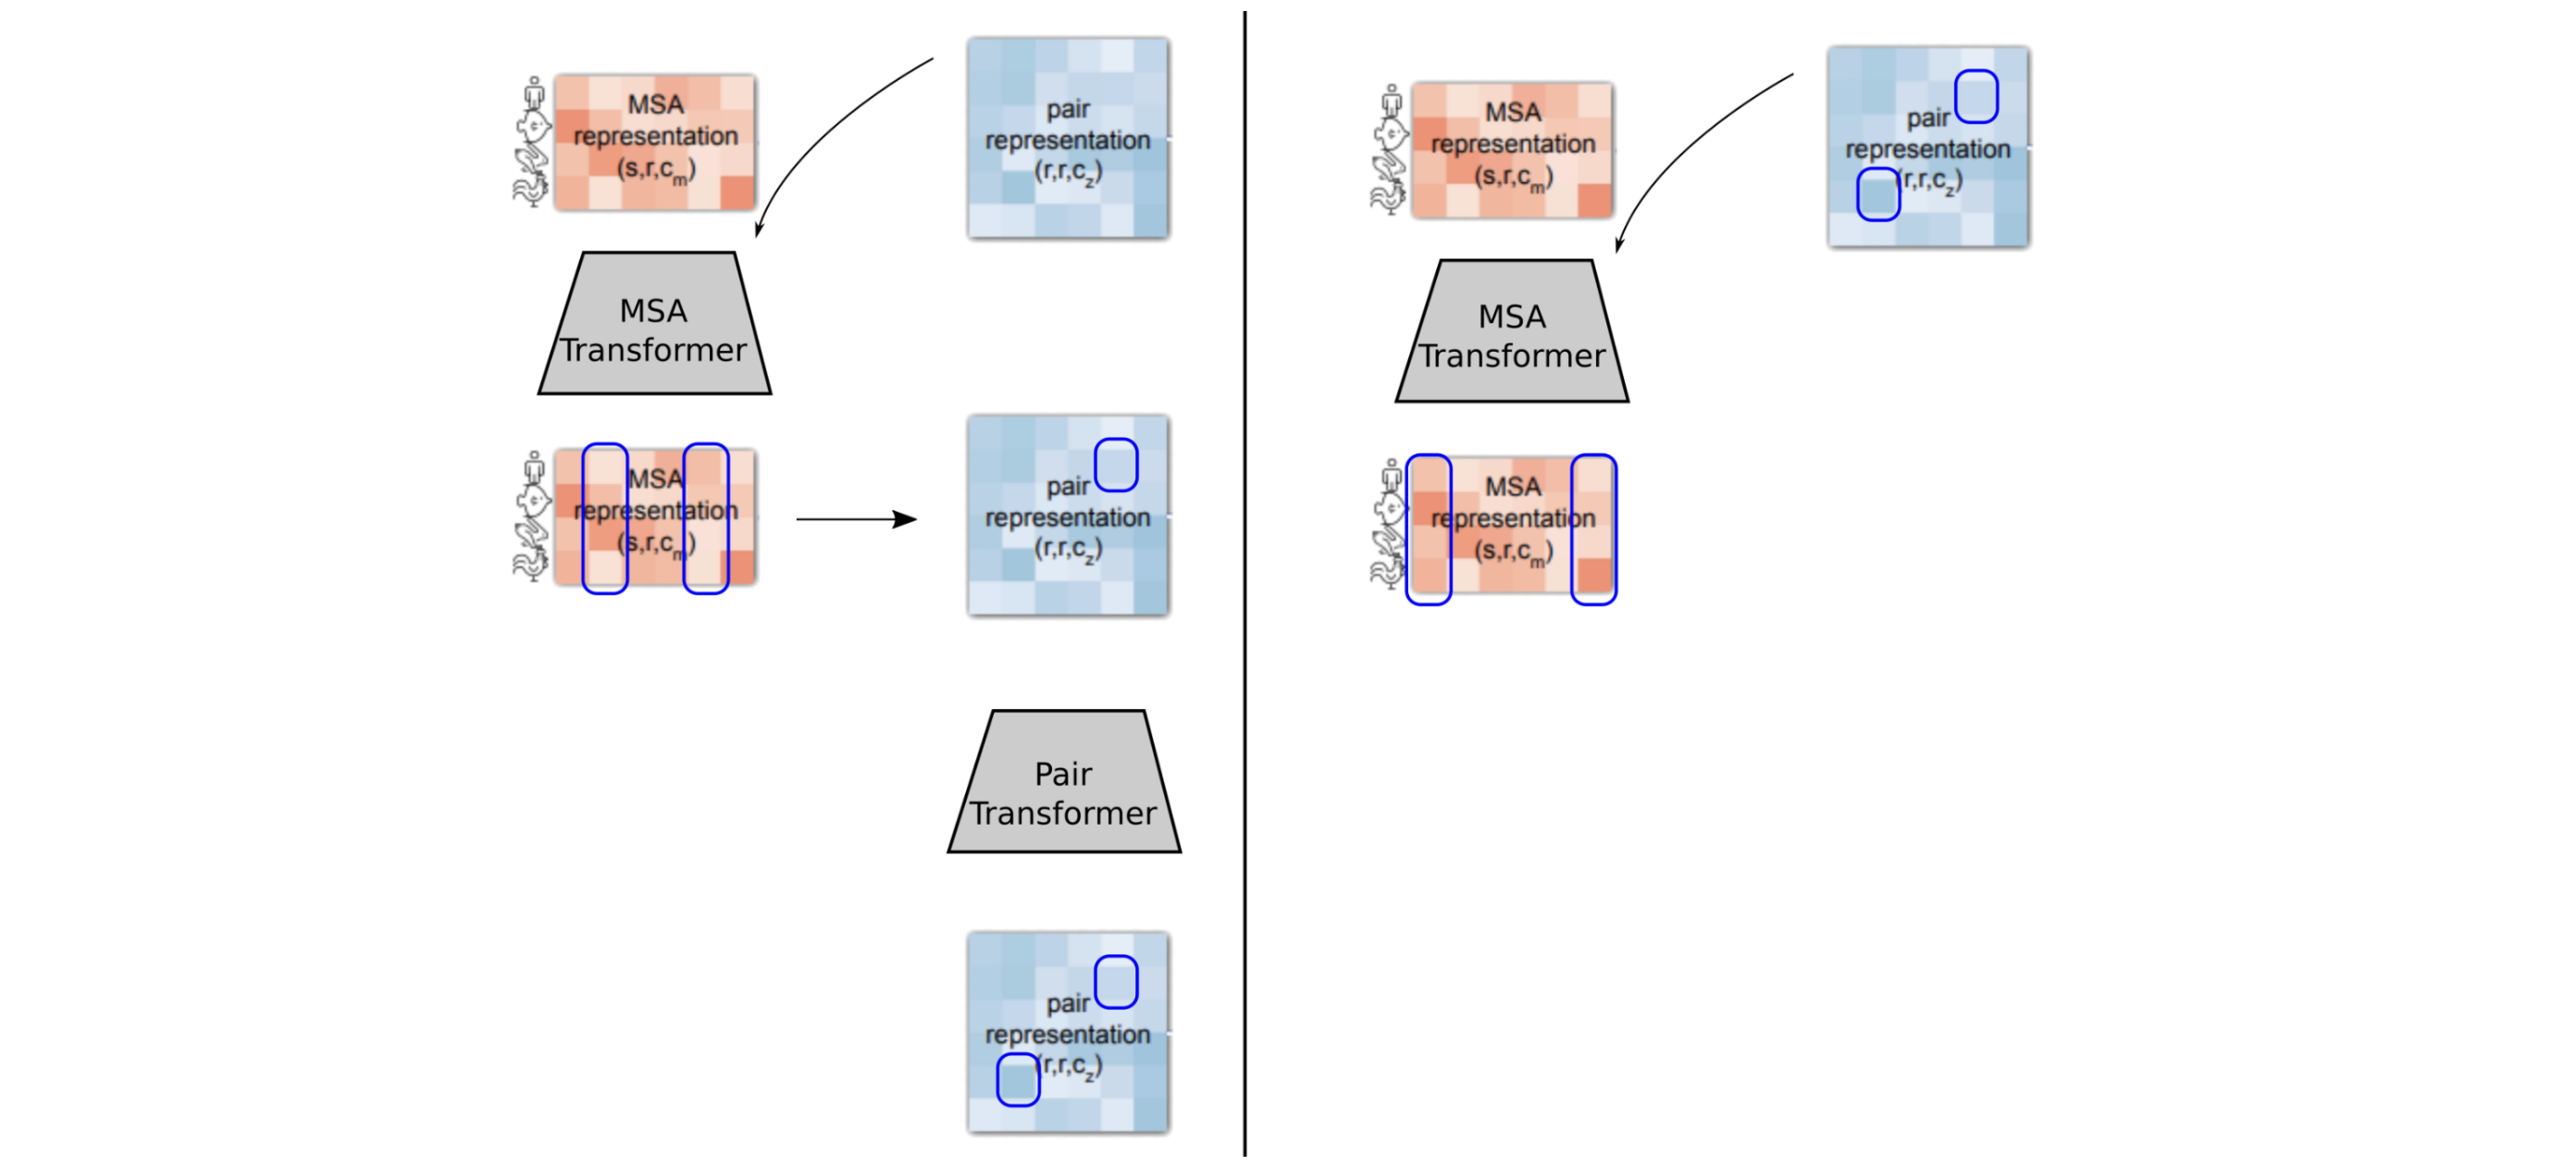

In [ ]:
#@markdown **<font color='#e59454'>Question Time! Run to Show Question**
import random
from IPython.display import display, HTML


question = "What is the role of the Evoformer in the AF2 architecture?"
correct_answer = "The Evoformer is responsible for extracting and refining information from the MSA and templates. It uses a transformer architecture to iteratively exchange information between the MSA and pairwise interactions, improving the model's characterization of protein structure through multiple cycles."
decoy_answers = ["The Evoformer functions as a classifier that categorizes amino acid sequences into predefined structural classes. It uses a supervised learning approach to label sequences based on known protein structures.",
                 "The Evoformer is a post-processing step that refines the final protein structure by adjusting predicted coordinates to fit known experimental data. It fine-tunes the structure predictions based on empirical measurements.",
                 "The Evoformer is a data preprocessing module that normalizes and filters raw protein sequences before they are input into the main prediction model. It ensures that only high-quality sequences are used for structure prediction."]

create_quiz(question, correct_answer, decoy_answers)

The pair of transformers works on the principle of Triangle inequality, where the sum of two sides must be greater than or equal to the third side. Attention is arranged in terms of triangles of residues. Using this theorem, we can determine the likely distance residues have from one another because the distance between three points can never break that theorem

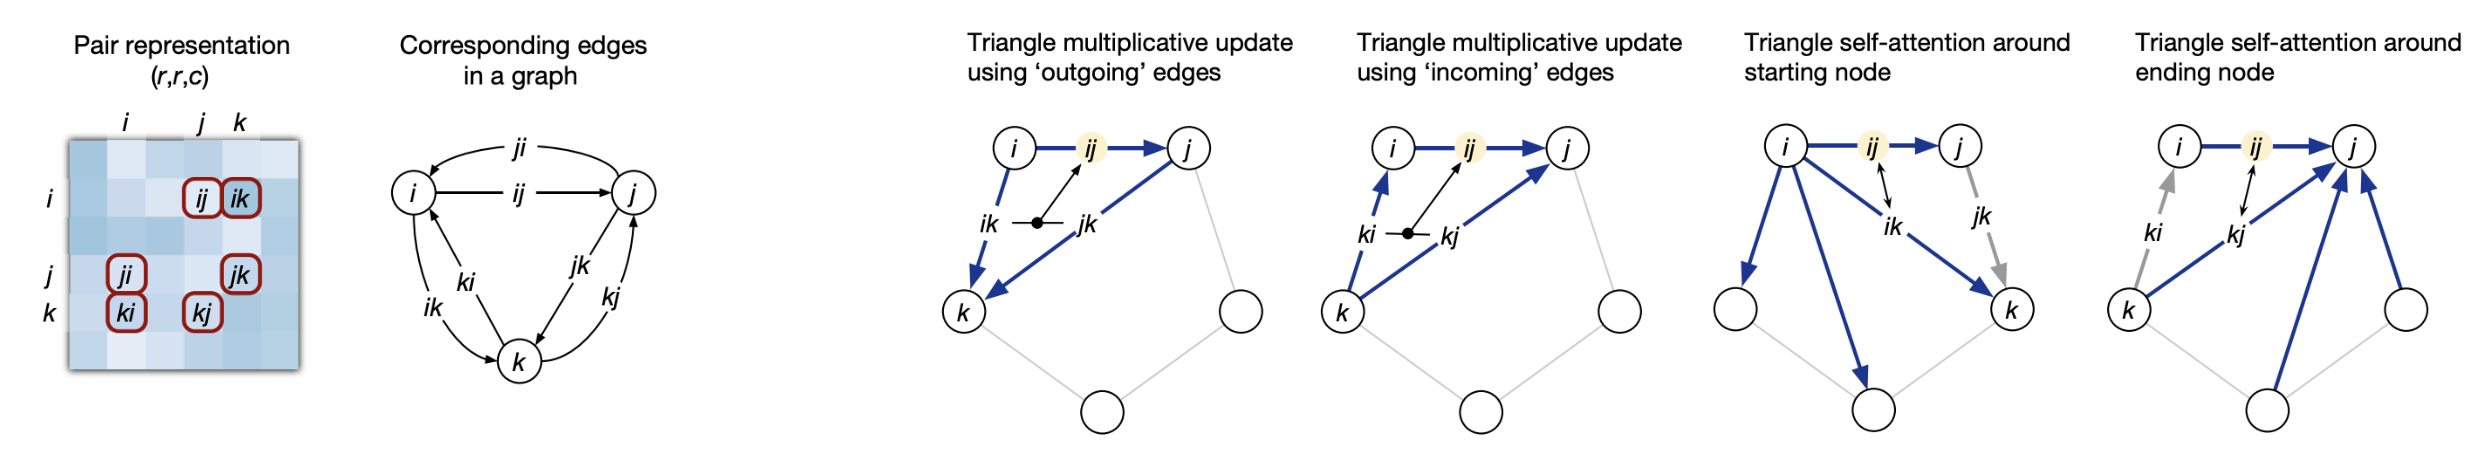

## **<font color='#569098'>Part 3: Structure module**

The structure module takes a refined MSA representation and refined pair representation, and uses this to construct a 3D model of the structure. The end result is a long list of cartesian coordinates representing the position of each atom of the protein (including side chains). Proteins are represented as a *residue gas*, where every amino acid is modeled as a triangle with points at the Nitrogen, R group Carbon and the Alpha Carbon. At the beginning of the structure module, all residues are placed at the origin of coordinates. At every step, the model produces a set of matrices that displace/rotate the residues in space. This representation does not reflect any physical or geometric assumptions, and as a result the network has a tendency to generate structural violations, which you can see in [this video](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-021-03819-2/MediaObjects/41586_2021_3819_MOESM6_ESM.mp4)

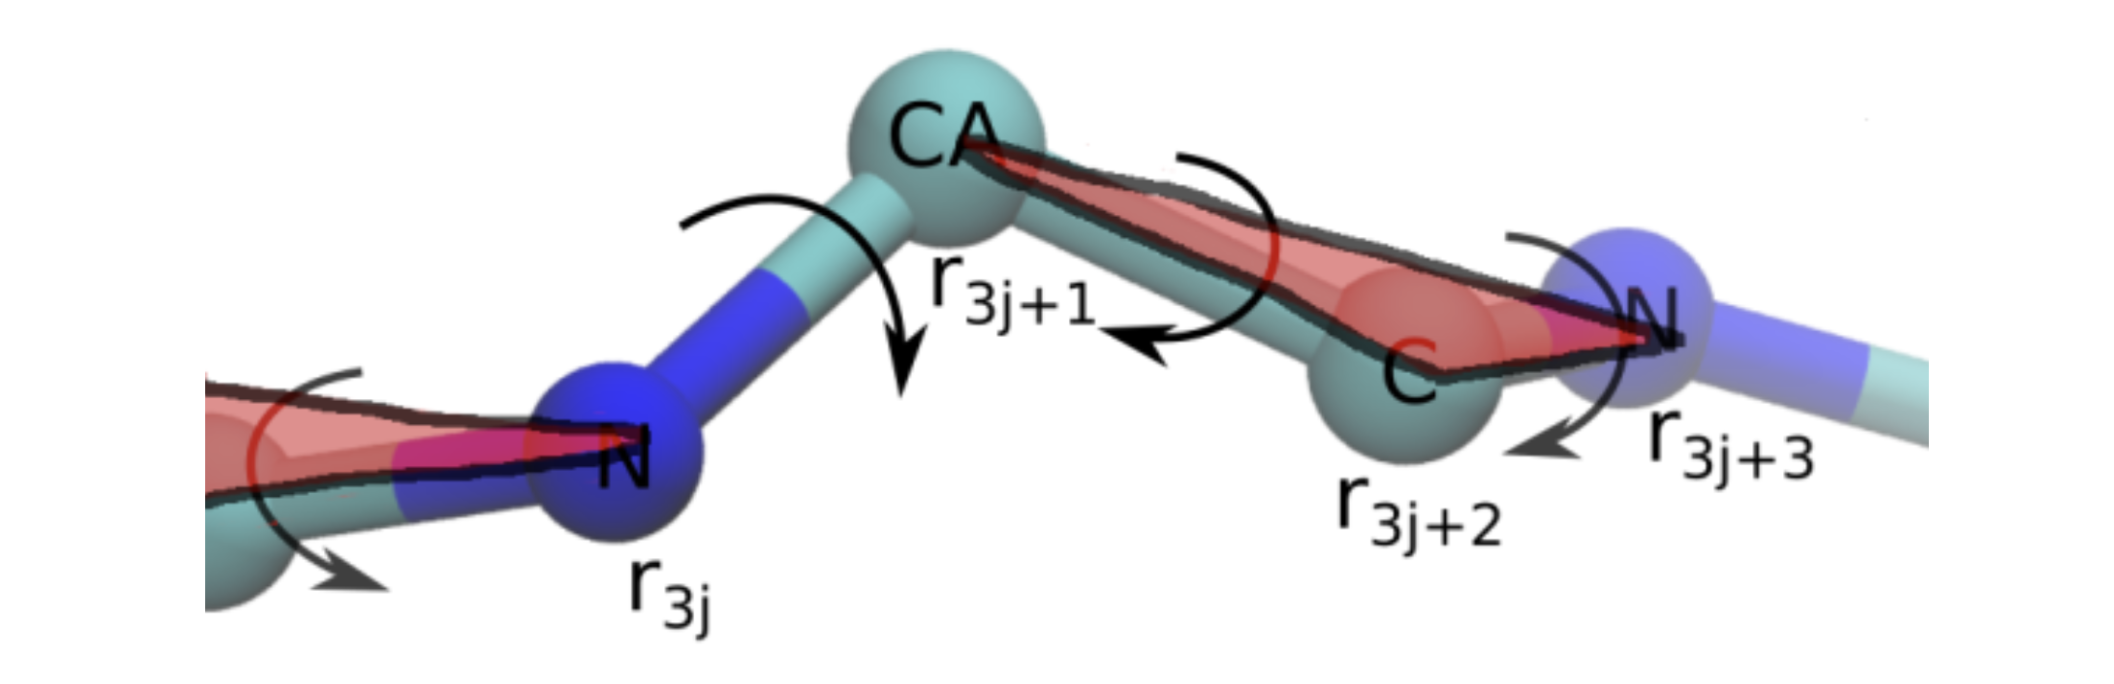

In [ ]:
#@markdown **<font color='#e59454'>Question Time! Run to Show Question**
import random
from IPython.display import display, HTML


question = "How does the structure module of AF2 generate the final protein structure?"
correct_answer = "The structure module of AlphaFold 2 takes the refined MSA and pair representations and constructs a three-dimensional model of the protein structure. It treats the protein as a 'residue gas,' where amino acids are represented as triangles. The module uses Invariant Point Attention (IPA) to ensure the structure is invariant to translations and rotations."
decoy_answers = ["The structure module of AlphaFold 2 utilizes a lattice-based approach to construct the protein model, where amino acids are placed on a fixed grid. It then applies optimization algorithms to minimize structural energy and achieve the final protein structure.",
                 "The structure module uses a generative adversarial network (GAN) to create the protein structure. It generates multiple possible structures and selects the best one based on adversarial feedback from a discriminator network.",
                 "The structure module generates the final protein structure by combining sequence motifs with a template library of known protein structures. It matches the input sequence to the closest template and adjusts the model accordingly."]
create_quiz(question, correct_answer, decoy_answers)

In [ ]:
#@markdown **<font color='#e59454'>Question Time! Run to Show Question**
import random
from IPython.display import display, HTML


question = "What is invariant point attention (IPA) and why is it important in AF2?"
correct_answer = "IPA is used in the structure module to ensure the model's predictions are invariant to translations and rotations of the protein. This is important because it allows the model to generalize better and requires less data to learn accurate protein structures."
decoy_answers = ["IPA is a technique used in AF2 to perform dimensionality reduction on protein data. It simplifies the representation of the protein structure by projecting it onto a lower-dimensional space, which helps in speeding up the computation.",
                 "IPA is a preprocessing step that aligns protein sequences with known structural templates. It ensures that the input sequences are appropriately matched with template structures before being processed by the main prediction model.",
                 "IPA is used to predict several possible orientations of the given protein, that way, more detailed information can be captured about its structure as it undergoes iterative refinement."]

create_quiz(question, correct_answer, decoy_answers)

In [ ]:
#@markdown **<font color='#e59454'>Question Time! Run to Show Question**
import random
from IPython.display import display, HTML


question = "What is the Frame Aligned Point Error (FAPE) and how is it used in AF2?"
correct_answer = "FAPE is a loss function that measures the accuracy of predicted atomic positions in the protein structure. It is similar to RMSD, but includes additional properties to prevent creating proteins with incorrect chirality"
decoy_answers = ["FAPE is an evaluation metric that measures the similarity between predicted protein structures and a library of experimental structures. It helps assess the accuracy of predictions by comparing them to known, experimentally determined structures.",
                 "FAPE is a regularization term added to the loss function to penalize large deviations in predicted bond angles. It helps ensure that the model predicts more physically realistic protein structures by constraining bond angles.",
                 "FAPE is a normalization technique used to adjust the scale of protein structures. It ensures that all predicted structures are on the same scale, which helps in comparing predictions across different models."]

create_quiz(question, correct_answer, decoy_answers)

An important note is that this model works *iteratively*. After generating a structure, the model takes all the information (MSA representation, pair representation, and predicted structure) and passes it back to the beginning of the Evoformer blocks. Check [this video](https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-021-03819-2/MediaObjects/41586_2021_3819_MOESM5_ESM.mp4) out of the model refining it's predictions across blocks over multiple iteractions.

In [ ]:
#@markdown **<font color='#e59454'>Question Time! Run to Show Question**

import random
from IPython.display import display, HTML

# Define the question and answers
question = "How does AF2 refine its predictions iteratively?"
correct_answer = "Predictions are iteratively refined by taking the predicted structure, MSA representation, and pair representation from one cycle and using them as input for another round of processing through the Evoformer module. The iterative process allows the model to continuously improve its predictions."
decoy_answers = ["AF2 utilizes a hierarchical neural network architecture, where different levels of the network specialize in distinct aspects of protein structure, refining predictions through a top-down feedback loop.",
                 "AF2 leverages ensemble learning, combining outputs from various independent models, and iteratively refines predictions by giving more weight to models that better align with known protein structures.",
                 "AF2 applies a genetic algorithm approach, where multiple variations of protein structures are generated and selectively combined in each iteration, akin to evolutionary selection, to improve predictions."]


create_quiz(question, correct_answer, decoy_answers)

## **<font color='#569098'>Onwards!**

Alphafold's architecture and concepts have inspired other deep-learning based protein folding algorithms as well, such as [RosettaTTAFold2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/RoseTTAFold2.ipynb) and [ESMFold](https://esmatlas.com/resources?action=fold). Each model has its advantages and disadvantages, dependent on its accuracy (with respect to various protein types), which oftentimes trades off with runtime (more accurate models take longer to run). Based on your desired task, whether it be designing a de novo protein or investigating a natural complex, it may be beneficial to choose a particular model to use. However, that is beyond the scope of this tutorial.

Another active field of progress is ***predicting folding with ligands and post-translational modifications***. At the time of writing, the state of the art includes [RosettaTTAFold All Atom](https://github.com/baker-laboratory/RoseTTAFold-All-Atom), [AF3](https://deepmind.google/technologies/alphafold/), [HelixFold3](https://github.com/PaddlePaddle/PaddleHelix), and [Chai1](https://www.chaidiscovery.com/blog/introducing-chai-1). These models are been able to account for ligands in folding, such as DNA or inhibitors. In particular, HelixFold-single and Chai1 look to circumvent MSA usage by using protein language models instead! Feel free to check all of them out!